In [1]:
import numpy as np
import random as pyrandom
from parse_input import *


# atoms.txt Содержит информацию об атомах, в колонках следующие данные:
# ID, x, y, z, сигма, эпсилон, заряд, 
# радиус Ван-дер-Ваальса, объём и еще две колонки типа строки; 
# радиус и объем и эти две колонки не используются далее
atoms = rd('atoms.txt', 1, 9)  # вместо 9 можно было и 7 взять

# bonds.txt Содержит информацию о связях, структура файла:
# ID1, ID2, Kr, r0
bonds = rd('bonds.txt', 2)

# angles.txt Содержит информацию об углах, структура файла:
# ID1, ID2, ID3, Kt, theta0
angles = rd('angles.txt', 3)

# dihedrals.txt Содержит информацию о двугранных углах, структура:
# ID1, ID2, ID3, ID4, V1, V2, V3, V4
# Все константы V1, V2, V3, V4 разделены на два, 
# при вычислении энергии делить их на два НЕ НАДО.
dihedrals = rd('dihedrals.txt', 4)

# neighbours.txt, two_bonds_neigh.txt, three_bonds_neigh.txt
# Содержат информацию о соседях непосредственных, 
# второго и третьего порядка соответственно. 
# У всех одна и та же структура:
# ID    id_1 id_2 ... id_n
# ID – индекс атома, id_1 id_2 ... id_n – индексы его соседей.
neighbours = rd('neighbours.txt')
two_bonds_neigh = rd('two_bonds_neigh.txt')
three_bonds_neigh = rd('three_bonds_neigh.txt')

In [5]:
from output import *
from energy import *
from itertools import cycle

N = 100  # 10000 # число итераций
l = len(atoms)  # число атомов в изучаемом белке
h = [0.02, 0.02, 0.02]  # размеры шагов по ортам в ангстремах
L = 3  # сколько шагов делаем вдоль каждого орта с учетом знака
S = 0
r = 10  # размер окрестности атома, по которой честно суммируем
M = 1000  # параметр, отвечающий за частоту вывода и сохранения информации
mas = []
tt = []
time_start = millis()

for k in range(0, N):
    atoms_old = atoms
    record = [0, 0, 0]
    num = pyrandom.randrange(0, l)
    nghb_d = nghb_dihedrals(dihedrals, num)
    nghb_a = nghb_angles(angles, num)
    nghb_b = nghb_bonds(bonds, num)
    nghb_nb = nghbnb(atoms, num, r)[0]
    nghbc = nghbnb(atoms, num, r)[1]
    [Cx, Cy, Cz] = coef_nb(atoms, num, nghbc)
    DE_elst = E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num) - \
              E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_nb)

    E_old = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
              three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)
    E_record = E_old

    candidates = np.array([0.0, 0.0, 0.0],  dtype=np.float64)
    parabola_arg = np.array([0.0, 0.0, 0.0], dtype=np.float64)
    tmp = atoms_old[num][1]
    
    a = cycle([Cx, Cy, Cz])
    al = cycle([1, 2, 3])
    c = next(a)
    where = next(al)
        
    for indent in [-1, 0, 1]:
        print("atom: ", tmp, " ind: ", indent, " sum: ", np.float64(tmp + indent * h[0]))
        parabola_arg[1 + indent] = np.float64(tmp + indent * h[0])
        atoms[num][where] = atoms_old[num][where] + indent * h[0]
        candidates[1 + indent] = DE_elst + c * indent * h[0] + \
                                 E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
                                   three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=False)
        # print(indent, 
        #   " value: ", 
        #   candidates[1 + indent], 
        #   " arg: ", 
        #   parabola_arg[1 + indent], 
        #   " atoms_old[num][1]: ", 
        #   tmp)
    # print(candidates)

    parabola_coefficients = {'a': 0.0, 'b': 0.0, 'c': 0.0}
    # print(parabola_arg)
    denominator = \
        parabola_arg[0] * np.power(parabola_arg[1], 2) - np.power(parabola_arg[0], 2) * parabola_arg[1] \
        - parabola_arg[0] * np.power(parabola_arg[2], 2) + parabola_arg[1] * np.power(parabola_arg[2], 2) \
        + np.power(parabola_arg[0], 2) * parabola_arg[2] - np.power(parabola_arg[1], 2) * parabola_arg[2]
    
    parabola_coefficients['a'] = \
        - parabola_arg[1] * candidates[0] + parabola_arg[2] * candidates[0] \
        + parabola_arg[0] * candidates[1] - parabola_arg[2] * candidates[1] \
        - parabola_arg[0] * candidates[2] + parabola_arg[1] * candidates[2]

    parabola_coefficients['b'] = \
        np.power(parabola_arg[1], 2) * candidates[0] - np.power(parabola_arg[2], 2) * candidates[0] \
        - np.power(parabola_arg[0], 2) * candidates[1] + parabola_arg[2] * candidates[1] \
        + np.power(parabola_arg[0], 2) * candidates[2] - np.power(parabola_arg[1], 2) * candidates[2]

    parabola_coefficients['c'] = \
        parabola_arg[1] * np.power(parabola_arg[2], 2) * candidates[0] - np.power(parabola_arg[1], 2) * parabola_arg[2] * candidates[0] \
        - parabola_arg[0] * np.power(parabola_arg[2], 2) * candidates[1] + np.power(parabola_arg[0], 2) * parabola_arg[2] * candidates[1] \
        + parabola_arg[0] * np.power(parabola_arg[1], 2) * candidates[2] - np.power(parabola_arg[0], 2) * parabola_arg[1] * candidates[2]

    # for arg in [0, 1, 2]:
    #     print("Arguments: ", parabola_arg[arg], " answer: ", candidates[arg])
        
    skip = False
    for coef in parabola_coefficients:
        parabola_coefficients[coef] = parabola_coefficients[coef] / denominator
        if not math.isnan(parabola_coefficients[coef]):
            print("Resulting coefficients: ", parabola_coefficients[coef])
        else:
            skip = True
    
    parabola_min_arg = 0
    if not skip:
        parabola_min_arg = - (parabola_coefficients['b'] ** 2) / (2 * parabola_coefficients['a'])
        atoms[num][1] = atoms_old[num][1] + parabola_min_arg    
    atoms[num][where] = atoms_old[num][where] + parabola_min_arg * h[where]
    E_new = DE_elst + c * parabola_min_arg + \
            E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
              three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=False)
    #  "-0.2" чтобы не учитвать погрешности в аппроксимации
    if E_new < E_record - 2:
        # record = [px, py, pz]
        E_record = E_new
        
    S = S + E_old - E_record
    mas.append(S)
    time_now = millis()
    ttm = (time_now - time_start) / 60000
    tt.append(ttm)
    
print(S)

#     for px in range(-L, L + 1):
#         for py in range(-L, L + 1):
#             for pz in range(-L, L + 1):
#                 atoms[num][1] = atoms_old[num][1] + px * h[0]
#                 atoms[num][2] = atoms_old[num][2] + py * h[1]
#                 atoms[num][3] = atoms_old[num][3] + pz * h[2]
#                 E_new = DE_elst + Cx * px * h[0] + Cy * py * h[1] + Cz * pz * h[2] + \
#                         E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh,
#                           three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=False)
#                 #  "-0.2" чтобы не учитвать погрешности в аппроксимации
#                 if E_new < E_record - 2:
#                     record = [px, py, pz]
#                     E_record = E_new
#     atoms = atoms_old
# 
#     atoms[num][1] = atoms_old[num][1] + record[0] * h[0]
#     atoms[num][2] = atoms_old[num][2] + record[1] * h[1]
#     atoms[num][3] = atoms_old[num][3] + record[2] * h[2]
# 
#     S = S + E_old - E_record
#     mas.append(S)
#     time_now = millis()
#     ttm = (time_now - time_start) / 60000
#     tt.append(ttm)
#     # приводимый далее блок можно закомментировать
#     # это просто печать результатов в файлы и отображения хода работы метода
#     # if k/M == int(k/M):
#     #     prp_atm(atoms,k)
#     #     os.system('./to-pdb atoms_out' + str(k) + '.csv output' + str(k) + '.pdb')
#     #     time_now = millis()
#     #     tm = (time_now - time_start)/60000
#     #     print("Число итераций {}; Энергия {}; Время (мин) {}".format(k,S,tm))
# print(S)


Coefs:  [-0.00058558  0.00054168 -0.00031629]


atom:  24.719  ind:  -1  sum:  24.699
atom:  24.719  ind:  0  sum:  24.719
atom:  24.719  ind:  1  sum:  24.739
Resulting coefficients:  -220.798453077
Resulting coefficients:  72907981.683
Resulting coefficients:  -134786.965819


Coefs:  [ -2.41090434e-04  -8.48360381e-05   5.54145295e-04]


atom:  8.397  ind:  -1  sum:  8.377
atom:  8.397  ind:  0  sum:  8.397
atom:  8.397  ind:  1  sum:  8.417
Resulting coefficients:  -437.187591207
Resulting coefficients:  93306631.9251
Resulting coefficients:  -30773.6039315


Coefs:  [-0.00044833  0.00108139 -0.00056147]


atom:  23.903  ind:  -1  sum:  23.883
atom:  23.903  ind:  0  sum:  23.903
atom:  23.903  ind:  1  sum:  23.923
Resulting coefficients:  -214.24068563
Resulting coefficients:  907633193.069
Resulting coefficients:  -122316.318007


Coefs:  [-0.00065227  0.00398819  0.00306096]


atom:  24.985  ind:  -1  sum:  24.965
atom:  24.985  ind:  0  sum:  24.985
atom:  24.985  ind:  1  sum:  25.005
Resulting coefficients:  -220.862371737
Resulting coefficients:  5274109627.86
Resulting coefficients:  -137880.962923


Coefs:  [ 0.00117063 -0.00238934  0.00387691]


atom:  30.198  ind:  -1  sum:  30.178
atom:  30.198  ind:  0  sum:  30.198
atom:  30.198  ind:  1  sum:  30.218
Resulting coefficients:  -523.060229518
Resulting coefficients:  -9722098132.21
Resulting coefficients:  -476545.692882


Coefs:  [ 0.00024237  0.00075205 -0.0015561 ]


atom:  19.685  ind:  -1  sum:  19.665
atom:  19.685  ind:  0  sum:  19.685
atom:  19.685  ind:  1  sum:  19.705
Resulting coefficients:  -267.53971329
Resulting coefficients:  434963010.459
Resulting coefficients:  -103591.611166


Coefs:  [-0.00029209  0.00012956 -0.00055706]


atom:  31.528  ind:  -1  sum:  31.508
atom:  31.528  ind:  0  sum:  31.528
atom:  31.528  ind:  1  sum:  31.548
Resulting coefficients:  -668.973194054
Resulting coefficients:  459286724.857
Resulting coefficients:  -664542.246758


Coefs:  [  4.86437906e-03  -5.13193114e-05   2.24636543e-03]
atom:  16.359  ind:  -1  sum:  16.339


atom:  16.359  ind:  0  sum:  16.359
atom:  16.359  ind:  1  sum:  16.379
Resulting coefficients:  -1237.77631512
Resulting coefficients:  -720718796.948
Resulting coefficients:  -330909.641595


Coefs:  [ 0.00046344 -0.00011476 -0.00067218]
atom:  15.927  ind:  -1 

 sum:  15.907
atom:  15.927  ind:  0  sum:  15.927
atom:  15.927  ind:  1  sum:  15.947
Resulting coefficients:  -414.355488348
Resulting coefficients:  87107543.4791
Resulting coefficients:  -104993.391468


Coefs:  [ 0.00033463  0.00053909 -0.0011545 ]
atom:  12.723  ind:  

-1  sum:  12.703
atom:  12.723  ind:  0  sum:  12.723
atom:  12.723  ind:  1  sum:  12.743
Resulting coefficients:  -1736.97699191
Resulting coefficients:  22858218.8927
Resulting coefficients:  -280739.043319


Coefs:  [ 0.00058504  0.00050818 -0.00166838]
atom:  5.225  ind:  -1  sum:  5.205
atom:  5.225  ind:  0  sum:  5.225
atom:  5.225  ind:  1  sum:  5.245


Resulting coefficients:  -1145.64558775
Resulting coefficients:  34964088.2605
Resulting coefficients:  -31186.484915


Coefs:  [ 0.00054555  0.00028054 -0.00040361]
atom:  12.504  ind:  -1  sum:  12.484
atom:  12.504  ind:  0  sum:  12.504


atom:  12.504  ind:  1  sum:  12.524
Resulting coefficients:  -1174.34254078
Resulting coefficients:  -126902729.854
Resulting coefficients:  -183310.20159


Coefs:  [-0.00015381  0.0026937  -0.00135446]
atom:  7.459  ind:  -1  sum:  7.439
atom:  7.459  ind:  0  sum:  7.459


atom:  7.459  ind:  1  sum:  7.479
Resulting coefficients:  -1074.60384132
Resulting coefficients:  -283896516.233
Resulting coefficients:  -59531.7416085
Coefs:  [ 0.00016182 -0.0002146  -0.00015332]


atom:  7.681  ind:  -1  sum:  7.661
atom:  7.681  ind:  0  sum:  7.681
atom:  7.681  ind:  1  sum:  7.701
Resulting coefficients:  -589.898622275
Resulting coefficients:  -9085612.89602
Resulting coefficients:  -34710.9848477


Coefs:  [-0.00032261 -0.00020178  0.00066029]
atom:  14.157  ind:  -1  sum:  14.137
atom:  14.157

  ind:  0  sum:  14.157
atom:  14.157  ind:  1  sum:  14.177
Resulting coefficients:  -161.720253651
Resulting coefficients:  66470256.0209
Resulting coefficients:  -32365.6358781


Coefs:  [ 0.00021888  0.00033901  0.00039421]
atom:  7.293  ind:  -1  sum:  7.273
atom:  7.293  ind:  0  sum:  7.293
atom:  7.293 

 ind:  1  sum:  7.313
Resulting coefficients:  -128.108110801
Resulting coefficients:  78571860.2509
Resulting coefficients:  -6824.55673718
Coefs:  [-0.00079758  0.00014966 -0.00102695]
atom:  17.211  ind:  -1  sum:  17.191
atom:  17.211  ind:  0  sum:  17.211
atom:  17.211  ind:  1  sum:  17.231


Resulting coefficients:  0.0
Resulting coefficients:  -1.13900540035e+39
Resulting coefficients:  6.51613411882e+31
Coefs:  [ 0.          0.00016016  0.00087336]


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: divide by zero encountered in double_scalars
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in subtract
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:268: RuntimeWarning: invalid value encountered in double_scalars


atom:  6.243  ind:  -1  sum:  6.223
atom:  6.243  ind:  0  sum:  6.243
atom:  6.243  ind:  1  sum:  6.263
Resulting coefficients:  -391.348606639
Resulting coefficients:  46182056.6272
Resulting coefficients:  -15226.3819636


Coefs:  [ 0.          0.00011131 -0.00022646]
atom:  22.822  ind:  -1  sum:  22.802
atom:  22.822  ind:  

0  sum:  22.822
atom:  22.822  ind:  1  sum:  22.842
Resulting coefficients:  -114.372894907
Resulting coefficients:  210347130.559
Resulting coefficients:  -59524.9411461
Coefs:  [ 0.         -0.00014806  0.00037472]


atom:  14.672  ind:  -1  sum:  14.652
atom:  14.672  ind:  0  sum:  14.672
atom:  14.672  ind:  1  sum:  14.692
Resulting coefficients:  -1292.15209205
Resulting coefficients:  170874154.022
Resulting coefficients:  -277792.877803


Coefs:  [  0.00000000e+00   3.42432074e-04   1.42104090e-05]
atom:  19.745  ind:  -1  sum:  19.725
atom:  19.745  ind:  0  sum:  19.745
atom:  19.745  ind:  1  sum:  19.765
Resulting coefficients:  -225.214108317
Resulting coefficients:  90117019.7477
Resulting coefficients:  -87718.0541331


Coefs:  [  0.00000000e+00  -1.96415233e-04   4.62676743e-05]
atom:  17.197  ind:  -1  sum:  17.177
atom:  17.197  ind:  0  sum:  

17.197
atom:  17.197  ind:  1  sum:  17.217
Resulting coefficients:  -383.334765629
Resulting coefficients:  2125278.56271
Resulting coefficients:  -113234.47724


Coefs:  [ 0.          0.00029462 -0.00025787]


atom:  25.945  ind:  -1  sum:  25.925
atom:  25.945  ind:  0  sum:  25.945
atom:  25.945  ind:  1  sum:  25.965
Resulting coefficients:  -395.862155542
Resulting coefficients:  991427581.988
Resulting coefficients:  -266290.907018


Coefs:  [  0.00000000e+00   3.22581386e-05   2.67758105e-04]


atom:  27.833  ind:  -1  sum:  27.813
atom:  27.833  ind:  0  sum:  27.833
atom:  27.833  ind:  1  sum:  27.853
Resulting coefficients:  -412.300982459
Resulting coefficients:  1784521164.61
Resulting coefficients:  -319208.292983


Coefs:  [ 0.          0.00520835  0.00458638]


atom:  23.393  ind:  -1  sum:  23.373
atom:  23.393  ind:  0  sum:  23.393
atom:  23.393  ind:  1  sum:  23.413
Resulting coefficients:  -1681.38151427
Resulting coefficients:  2965067538.88
Resulting coefficients:  -919410.276278


Coefs:  [ 0.          0.00114355 -0.00028879]


atom:  15.249  ind:  -1  sum:  15.229
atom:  15.249  ind:  0  sum:  15.249
atom:  15.249  ind:  1  sum:  15.269
Resulting coefficients:  -145.659076977
Resulting coefficients:  49646469.5891
Resulting coefficients:  -33829.6190977


Coefs:  [ 0.          0.00013392  0.00018249]


atom:  25.717  ind:  -1  sum:  25.697
atom:  25.717  ind:  0  sum:  25.717
atom:  25.717  ind:  1  sum:  25.737
Resulting coefficients:  -279.408486553
Resulting coefficients:  1047469788.4
Resulting coefficients:  -184673.352138


Coefs:  [ 0.         -0.00011166 -0.00055254]


atom:  23.704  ind:  -1  sum:  23.684
atom:  23.704  ind:  0  sum:  23.704
atom:  23.704  ind:  1  sum:  23.724
Resulting coefficients:  -693.696060772
Resulting coefficients:  691244190.15


Resulting coefficients:  -389465.323185
Coefs:  [ 0.          0.00012741 -0.0007735 ]


atom:  28.131  ind:  -1  sum:  28.111
atom:  28.131  ind:  0  sum:  28.131
atom:  28.131  ind:  1  sum:  28.151
Resulting coefficients:  -620.889389927
Resulting coefficients:  584352901.783
Resulting coefficients:  -491005.688341


Coefs:  [  0.00000000e+00   6.03129139e-04   6.69869847e-05]
atom:  13.867  ind: 

 -1  sum:  13.847
atom:  13.867  ind:  0  sum:  13.867
atom:  13.867  ind:  1  sum:  13.887
Resulting coefficients:  -82.1464160013
Resulting coefficients:  50141380.3183
Resulting coefficients:  -15777.9375492


Coefs:  [  0.00000000e+00   1.00179664e-03  -8.74781598e-05]


atom:  20.839  ind:  -1  sum:  20.819
atom:  20.839  ind:  0  sum:  20.839
atom:  20.839  ind:  1  sum:  20.859
Resulting coefficients:  -1117.76163012
Resulting coefficients:  -585469010.523
Resulting coefficients:  -484915.071975


Coefs:  [ 0.          0.00019285 -0.00026867]


atom:  13.727  ind:  -1  sum:  13.707
atom:  13.727  ind:  0  sum:  13.727
atom:  13.727  ind:  1  sum:  13.747
Resulting coefficients:  -948.976601809
Resulting coefficients:  

-254205165.005
Resulting coefficients:  -178532.417964
Coefs:  [ 0.          0.00064231 -0.00032973]


atom:  24.515  ind:  -1  sum:  24.495
atom:  24.515  ind:  0  sum:  24.515
atom:  24.515  ind:  1  sum:  24.535
Resulting coefficients:  -982.320570622
Resulting coefficients:  8986396275.78
Resulting coefficients:  -590127.519454


Coefs:  [  0.00000000e+00  -5.98763371e-05  -7.97189561e-04]


atom:  8.13  ind:  -1  sum:  8.11
atom:  8.13  ind:  0  sum:  8.13
atom:  8.13  ind:  1  sum:  8.15
Resulting coefficients:  0.0
Resulting coefficients:  -7.06770528575e+36
Resulting coefficients:  1.94059436018e+30


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in double_scalars
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in subtract


Coefs:  [ 0.          0.00096343 -0.0016385 ]


atom:  18.588  ind:  -1  sum:  18.568
atom:  18.588  ind:  0  sum:  18.588
atom:  18.588  ind:  1  sum:  18.608
Resulting coefficients:  -90.1111844707
Resulting coefficients:  3575391904.39
Resulting coefficients:  

-31275.7486864
Coefs:  [ 0.          0.0001075  -0.00063488]


atom:  23.198  ind:  -1  sum:  23.178
atom:  23.198  ind:  0  sum:  23.198
atom:  23.198  ind:  1  sum:  23.218
Resulting coefficients:  3286.77070021
Resulting coefficients:  -673535659.453
Resulting coefficients:  1767262.41824


Coefs:  [ 0.         -0.00550293  0.00310665]
atom: 

 9.981  ind:  -1  sum:  9.961
atom:  9.981  ind:  0  sum:  9.981
atom:  9.981  ind:  1  sum:  10.001
Resulting coefficients:  -1959.96740768
Resulting coefficients: 

 -663871070.031
Resulting coefficients:  -194743.408447
Coefs:  [  0.00000000e+00  -6.29844404e-05   1.07906016e-04]


atom:  19.102  ind:  -1  sum:  19.082
atom:  19.102  ind:  0  sum:  19.102
atom:  19.102  ind:  1  sum:  19.122
Resulting coefficients:  -296.454458435
Resulting coefficients:  373722700.109
Resulting coefficients:  -108076.198903


Coefs:  [ 0.         -0.00301681 -0.00136391]


atom:  16.537  ind:  -1  sum:  16.517
atom:  16.537  ind:  0  sum:  16.537
atom:  16.537  ind:  1  sum:  16.557
Resulting coefficients:  -2189.93581503
Resulting coefficients:  2824141255.5
Resulting coefficients:  -598338.059409


Coefs:  [ 0.         -0.00033725  0.00011047]


atom:  12.498  ind:  -1  sum:  12.478
atom:  12.498  ind:  0  sum:  12.498
atom:  12.498  ind:  1  sum:  12.518
Resulting coefficients:  5623.45753598
Resulting coefficients:  -1362965611.99
Resulting coefficients:  877129.683707


Coefs:  [ 0.         -0.00360099 -0.01648668]


atom:  25.798  ind:  -1  sum:  25.778
atom:  25.798  ind:  0  sum:  25.798
atom:  25.798  ind:  1  sum:  25.818
Resulting coefficients:  406.498941291
Resulting coefficients:  5644749136.77
Resulting coefficients:  270189.315193


Coefs:  [ 0.          0.0006692  -0.00044777]


atom:  13.129  ind:  -1  sum:  13.109
atom:  13.129  ind:  0  sum:  13.129
atom:  13.129  ind:  1  sum:  13.149
Resulting coefficients:  0.0
Resulting coefficients:  -1.84900395814e+37
Resulting coefficients: 

 1.85192999928e+30
Coefs:  [  0.00000000e+00   2.66002988e-05  -2.21000839e-03]


atom:  15.914  ind:  -1  sum:  15.894
atom:  15.914  ind:  0  sum:  15.914
atom:  15.914  ind:  1  sum:  15.934
Resulting coefficients:  -400.015402144


Resulting coefficients:  771206679.729
Resulting coefficients:  -101230.596222
Coefs:  [  0.00000000e+00  -9.60699610e-05  -1.54649292e-04]
atom:  11.868  ind: 

 -1  sum:  11.848
atom:  11.868  ind:  0  sum:  11.868
atom:  11.868  ind:  1  sum:  11.888
Resulting coefficients:  -96.1104596879
Resulting coefficients:  197214593.922
Resulting coefficients:  -13538.6680541


Coefs:  [ 0.         -0.00016999 -0.00035973]
atom: 

 10.635  ind:  -1  sum:  10.615
atom:  10.635  ind:  0  sum:  10.635
atom:  10.635  ind:  1  sum:  10.655
Resulting coefficients:  -695.533604184
Resulting coefficients:  114764250.944
Resulting coefficients:  -78537.0007201


Coefs:  [ 0.         -0.00305625 -0.00147274]


atom:  6.782  ind:  -1  sum:  6.762
atom:  6.782  ind:  0  sum:  6.782
atom:  6.782  ind:  1  sum:  6.802
Resulting coefficients:  -959.212946475
Resulting coefficients:  357732132.584
Resulting coefficients:  -44134.4211045


Coefs:  [ 0.          0.00010061  0.00123722]


atom:  21.216  ind:  -1  sum:  21.196
atom:  21.216  ind:  0  sum:  21.216
atom:  21.216  ind:  1  sum:  21.236
Resulting coefficients:  196.967352096
Resulting coefficients:  -4483576753.47
Resulting coefficients:  88742.0372077


Coefs:  [ 0.          0.00095792  0.00921501]


atom:  30.887  ind:  -1  sum:  30.867
atom:  30.887  ind:  0  sum:  30.887
atom:  30.887  ind:  1  sum:  30.907
Resulting coefficients:  -2038.98510788
Resulting coefficients:  -13946324059.4
Resulting coefficients:  -1943704.62295


Coefs:  [ 0.          0.00138889 -0.00163722]


atom:  21.198  ind:  -1  sum:  21.178
atom:  21.198  ind:  0  sum:  21.198
atom:  21.198  ind:  1  sum:  21.218
Resulting coefficients:  -1249.12580254
Resulting coefficients:  2695101185.28
Resulting coefficients:  -560872.118476


Coefs:  [ 0.          0.00082535  0.0004397 ]


atom:  10.081  ind:  -1  sum:  10.061
atom:  10.081  ind:  0  sum:  10.081
atom:  10.081  ind:  1  sum:  10.101
Resulting coefficients:  -268.522753745
Resulting coefficients:  141840829.874
Resulting coefficients:  -27259.590483


Coefs:  [ 0.         -0.00076153 -0.00103159]


atom:  25.526  ind:  -1  sum:  25.506
atom:  25.526  ind:  0  sum:  25.526
atom:  25.526  ind:  1  sum:  25.546
Resulting coefficients:  -582.60800879
Resulting coefficients:  1837547774.91
Resulting coefficients:  -379363.243244


Coefs:  [ 0.         -0.00128693  0.00181567]
atom:  26.082 

 ind:  -1  sum:  26.062
atom:  26.082  ind:  0  sum:  26.082
atom:  26.082  ind:  1  sum:  26.102
Resulting coefficients:  -3021.48582572
Resulting coefficients:  -4274740526.84
Resulting coefficients:  -2053747.83122


Coefs:  [ 0.          0.00446055 -0.002315  ]


atom:  22.145  ind:  -1  sum:  22.125
atom:  22.145  ind:  0  sum:  22.145
atom:  22.145  ind:  1  sum:  22.165
Resulting coefficients:  -869.58880204
Resulting coefficients:  -10556262419.8
Resulting coefficients: 

 -425702.063103
Coefs:  [ 0.         -0.00161294  0.00134996]


atom:  26.615  ind:  -1  sum:  26.595
atom:  26.615  ind:  0  sum:  26.615
atom:  26.615  ind:  1  sum:  26.635
Resulting coefficients:  2056.25489217
Resulting coefficients:  -18277712538.5
Resulting coefficients:  1455898.82605


Coefs:  [ 0.         -0.00361371  0.00890161]
atom:  20.413  ind:  -1  sum: 

 20.393
atom:  20.413  ind:  0  sum:  20.413
atom:  20.413  ind:  1  sum:  20.433
Resulting coefficients:  -181.257278047
Resulting coefficients:  -2232998987.75
Resulting coefficients:  -75364.219899


Coefs:  [  0.00000000e+00  -1.53183647e-44  -6.83232732e-44]


atom:  3.08438890306e+15  ind:  -1  sum:  3.08438890306e+15
atom:  3.08438890306e+15  ind:  0  sum:  3.08438890306e+15
atom:  3.08438890306e+15  ind:  1  sum:  3.08438890306e+15
Resulting coefficients:  -inf


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in double_scalars
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in double_scalars


Coefs:  [ 0.          0.00082601  0.00016382]
atom: 

 10.077  ind:  -1  sum:  10.057
atom:  10.077  ind:  0  sum:  10.077
atom:  10.077  ind:  1  sum:  10.097
Resulting coefficients:  -236.805732154
Resulting coefficients:  140076095.889
Resulting coefficients:  -24023.3316106


Coefs:  [ 0.          0.00123369  0.00077719]


atom:  20.112  ind:  -1  sum:  20.092
atom:  20.112  ind:  0  sum:  20.112
atom:  20.112  ind:  1  sum:  20.132
Resulting coefficients:  4.50359963874e+21
Resulting coefficients:  -6.60254529504e+38
Resulting coefficients:  2.74273662512e+31


Coefs:  [ 0.         -0.00014728  0.00088569]
atom: 

 5.799  ind:  -1  sum:  5.779
atom:  5.799  ind:  0  sum:  5.799
atom:  5.799  ind:  1  sum:  5.819
Resulting coefficients:  -512.691366875
Resulting coefficients:  54468885.1912
Resulting coefficients:  -17212.6042672


Coefs:  [ 0.          0.00061117 -0.00014177]
atom:  

16.766  ind:  -1  sum:  16.746
atom:  16.766  ind:  0  sum:  16.766
atom:  16.766  ind:  1  sum:  16.786
Resulting coefficients:  -410.115384396
Resulting coefficients:  133823421.112
Resulting coefficients:  -115153.484048


Coefs:  [  0.00000000e+00  -6.76994979e-05  -3.86749442e-04]
atom: 

 14.122  ind:  -1  sum:  14.102
atom:  14.122  ind:  0  sum:  14.122
atom:  14.122  ind:  1  sum:  14.142
Resulting coefficients:  -287.535382523
Resulting coefficients:  -52331146.501
Resulting coefficients:  -57257.7181893


Coefs:  [ 0.         -0.00020586 -0.00224719]


atom:  26.225  ind:  -1  sum:  26.205
atom:  26.225  ind:  0  sum:  26.225
atom:  26.225  ind:  1  sum:  26.245
Resulting coefficients:  2941.79654431
Resulting coefficients:  -11439853216.7
Resulting coefficients:  2021955.69627


Coefs:  [  0.00000000e+00   5.28168188e-05   1.86357462e-03]


atom:  8.578  ind:  -1  sum:  8.558
atom:  8.578  ind:  0  sum:  8.578
atom:  8.578  ind:  1  sum:  8.598
Resulting coefficients:  -4.83183818587e+15
Resulting coefficients:  -2.95835197413e+31
Resulting coefficients:  7.24557863088e+24


Coefs:  [  0.00000000e+00  -1.07458518e-36  -2.70570778e-36]
atom: 

 544207227168.0  ind:  -1  sum:  544207227168.0
atom:  544207227168.0  ind:  0  sum:  544207227168.0
atom:  544207227168.0  ind:  1  sum:  544207227168.0


Coefs:  [ 0.          0.00119689  0.00101854]


atom:  11.676  ind:  -1  sum:  11.656
atom:  11.676  ind:  0  sum:  11.676
atom:  11.676  ind:  1  sum:  11.696
Resulting coefficients:  2987.6835877
Resulting coefficients:  -1977750824.15
Resulting coefficients:  406863.100239


Coefs:  [ 0.          0.00059657  0.00140407]


atom:  13.313  ind:  -1  sum:  13.293
atom:  13.313  ind:  0  sum:  13.313
atom:  13.313  ind:  1  sum:  13.333
Resulting coefficients:  -623.493705423
Resulting coefficients:  -21790988.7775
Resulting coefficients:  -110337.377683


Coefs:  [ 0.          0.00021034  0.00056396]
atom:  26.725 

 ind:  -1  sum:  26.705
atom:  26.725  ind:  0  sum:  26.725
atom:  26.725  ind:  1  sum:  26.745
Resulting coefficients:  0.0
Resulting coefficients:  -3.15125140867e+43
Resulting coefficients:  7.32263681231e+35


Coefs:  [ 0.         -0.00849477 -0.0073696 ]
atom:  24.566  ind:  -1  sum:  24.546
atom:  24.566  ind: 

 0  sum:  24.566
atom:  24.566  ind:  1  sum:  24.586
Resulting coefficients:  0.0
Resulting coefficients:  -2.71517043269e+44
Resulting coefficients:  7.49160693759e+36


Coefs:  [  0.00000000e+00   2.01096882e-04  -4.82658651e-05]


atom:  6.333  ind:  -1  sum:  6.313
atom:  6.333  ind:  0  sum:  6.333
atom:  6.333  ind:  1  sum:  6.353
Resulting coefficients:  -1100.85502999
Resulting coefficients:  155259019.567
Resulting coefficients:  -44085.4763656


Coefs:  [ 0.          0.001195    0.00050665]
atom: 

 21.753  ind:  -1  sum:  21.733
atom:  21.753  ind:  0  sum:  21.753
atom:  21.753  ind:  1  sum:  21.773
Resulting coefficients:  -227.437010262
Resulting coefficients:  642397855.835
Resulting coefficients:  -107545.379286


Coefs:  [ 0.          0.00156355  0.00013   ]


atom:  26.321  ind:  -1  sum:  26.301
atom:  26.321  ind:  0  sum:  26.321
atom:  26.321  ind:  1  sum:  26.341
Resulting coefficients:  -1223.54119892
Resulting coefficients:  313678201.734
Resulting coefficients:  -847026.695765


Coefs:  [  0.00000000e+00   2.84766452e-04  -8.76624045e-06]


atom:  13.03  ind:  -1  sum:  13.01
atom:  13.03  ind:  0  sum:  13.03
atom:  13.03  ind:  1  sum:  13.05
Resulting coefficients:  -232.470661715
Resulting coefficients:  146904956.696
Resulting coefficients:  -39423.4428654


Coefs:  [  0.00000000e+000   3.36730484e-141   1.73480621e-141]


atom:  9.2375644501e+46  ind:  -1  sum:  9.2375644501e+46
atom:  9.2375644501e+46  ind:  0  sum:  9.2375644501e+46
atom:  9.2375644501e+46  ind:  1  sum:  9.2375644501e+46
Resulting coefficients:  -inf


Coefs:  [ 0.          0.00291105  0.0029534 ]


atom:  17.536  ind:  -1  sum:  17.516
atom:  17.536  ind:  0  sum:  17.536
atom:  17.536  ind:  1  sum:  17.556
Resulting coefficients:  -599.639189958
Resulting coefficients:  3355606751.91
Resulting coefficients:  -184370.236176


Coefs:  [ 0.         -0.00023112  0.0004991 ]


atom:  13.521  ind:  -1  sum:  13.501
atom:  13.521  ind:  0  sum:  13.521
atom:  13.521  ind:  1  sum:  13.541
Resulting coefficients:  -69.4279077725
Resulting coefficients:  247200596.092
Resulting coefficients:  -12697.1484781


Coefs:  [ 0.         -0.00032194  0.00071299]


atom:  22.992  ind:  -1  sum:  22.972
atom:  22.992  ind:  0  sum:  22.992
atom:  22.992  ind:  1  sum:  23.012
Resulting coefficients:  -1246.04964392
Resulting coefficients:  -2178818605.64
Resulting coefficients: 

 -658059.987855
Coefs:  [ 0.         -0.00082739  0.00109032]


atom:  18.226  ind:  -1  sum:  18.206
atom:  18.226  ind:  0  sum:  18.226
atom:  18.226  ind:  1  sum:  18.246
Resulting coefficients:  -1537.05406613
Resulting coefficients:  -97297476.0765
Resulting coefficients:  -510024.258819


Coefs:  [  0.00000000e+00  -2.00400295e-38  -3.34971184e-39]


atom:  6.99386607006e+12  ind:  -1  sum:  6.99386607006e+12
atom:  6.99386607006e+12  ind:  0  sum:  6.99386607006e+12
atom:  6.99386607006e+12  ind:  1  sum:  6.99386607006e+12
Resulting coefficients:  -inf
Resulting coefficients:  -inf
Resulting coefficients:  inf


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in double_scalars


Coefs:  [ 0.  0.  0.]


atom:  1.94301870325e+15  ind:  -1  sum:  1.94301870325e+15
atom:  1.94301870325e+15  ind:  0  sum:  1.94301870325e+15
atom:  1.94301870325e+15  ind:  1  sum:  1.94301870325e+15


Coefs:  [ 0.  0.  0.]


atom:  23.996  ind:  -1  sum:  23.976
atom:  23.996  ind:  0  sum:  23.996
atom:  23.996  ind:  1  sum:  24.016


Coefs:  [ 0.  0.  0.]


atom:  27.032  ind:  -1  sum:  27.012
atom:  27.032  ind:  0  sum:  27.032
atom:  27.032  ind:  1  sum:  27.052


Coefs:  [ 0.  0.  0.]


atom:  17.401  ind:  -1  sum:  17.381
atom:  17.401  ind:  0  sum:  17.401
atom:  17.401  ind:  1  sum:  17.421


Coefs:  [ 0.  0.  0.]


atom:  24.299  ind:  -1  sum:  24.279
atom:  24.299  ind:  0  sum:  24.299
atom:  24.299  ind:  1  sum:  24.319


Coefs:  [ 0.  0.  0.]
atom:  3.08438890306e+15  ind:  -1

  sum:  3.08438890306e+15
atom:  3.08438890306e+15  ind:  0  sum:  3.08438890306e+15
atom:  3.08438890306e+15  ind:  1  sum:  3.08438890306e+15


Coefs:  [ 0.  0.  0.]


atom:  20.644  ind:  -1  sum:  20.624
atom:  20.644  ind:  0  sum:  20.644
atom:  20.644  ind:  1  sum:  20.664


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:256: RuntimeWarning: invalid value encountered in subtract
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in subtract


Coefs:  [ 0.  0.  0.]


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in subtract
D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: RuntimeWarning: invalid value encountered in subtract


atom:  -inf  ind:  -1  sum:  -inf
atom:  -inf  ind:  0  sum:  -inf
atom:  -inf  ind:  1  sum:  -inf


D:\Users\Devjiu\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


Coefs:  [ 0.  0.  0.]


atom:  9.721  ind:  -1  sum:  9.701
atom:  9.721  ind:  0  sum:  9.721
atom:  9.721  ind:  1  sum:  9.741


Coefs:  [ 0.  0.  0.]


atom:  12.677  ind:  -1  sum:  12.657
atom:  12.677  ind:  0  sum:  12.677
atom:  12.677  ind:  1  sum:  12.697


Coefs:  [ 0.  0.  0.]


atom:  19.668  ind:  -1  sum:  19.648
atom:  19.668  ind:  0  sum:  19.668
atom:  19.668  ind:  1  sum:  19.688


Coefs:  [ 0.  0.  0.]


atom:  10.127  ind:  -1  sum:  10.107
atom:  10.127  ind:  0  sum:  10.127
atom:  10.127  ind:  1  sum:  10.147


Coefs:  [ 0.  0.  0.]


atom:  1.60815996407e+14  ind:  -1  sum:  1.60815996407e+14
atom:  1.60815996407e+14  ind:  0  sum:  1.60815996407e+14
atom:  1.60815996407e+14  ind:  1  sum:  1.60815996407e+14


Coefs:  [ 0.  0.  0.]


atom:  8.106  ind:  -1  sum:  8.086
atom:  8.106  ind:  0  sum:  8.106
atom:  8.106  ind:  1  sum:  8.126


Coefs:  [ 0.  0.  0.]
atom: 

 22.222  ind:  -1  sum:  22.202
atom:  22.222  ind:  0  sum:  22.222
atom:  22.222  ind:  1  sum:  22.242


Coefs:  [ 0.  0.  0.]
atom:  30.283 

 ind:  -1  sum:  30.263
atom:  30.283  ind:  0  sum:  30.283
atom:  30.283  ind:  1  sum:  30.303


Coefs:  [ 0.  0.  0.]


atom:  18.274  ind:  -1  sum:  18.254
atom:  18.274  ind:  0  sum:  18.274
atom:  18.274  ind:  1  sum:  18.294


Coefs:  [ 0.  0.  0.]


atom:  24.091  ind:  -1  sum:  24.071
atom:  24.091  ind:  0  sum:  24.091
atom:  24.091  ind:  1  sum:  24.111


Coefs:  [ 0.  0.  0.]


atom:  8.134  ind:  -1  sum:  8.114
atom:  8.134  ind:  0  sum:  8.134
atom:  8.134  ind:  1  sum:  8.154


Coefs:  [ 0.  0.  0.]


atom:  11.617  ind:  -1  sum:  11.597
atom:  11.617  ind:  0  sum:  11.617
atom:  11.617  ind:  1  sum:  11.637


Coefs:  [ 0.  0.  0.]


atom:  25.547  ind:  -1  sum:  25.527
atom:  25.547  ind:  0  sum:  25.547
atom:  25.547  ind:  1  sum:  25.567


Coefs:  [ 0.  0.  0.]


atom:  22.582  ind:  -1  sum:  22.562
atom:  22.582  ind:  0  sum:  22.582
atom:  22.582  ind:  1  sum:  22.602
nan


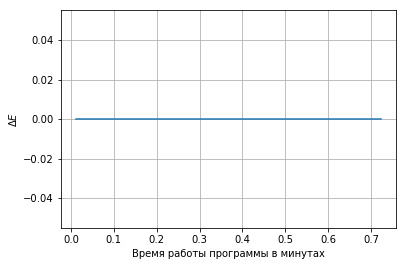

In [3]:
import matplotlib.pyplot as plt

mmas = - np.array(mas)

plt.plot(tt, mmas)
plt.xlabel(r"Время работы программы в минутах")
plt.ylabel(r"$\Delta E$")
plt.grid(True)
plt.show()

-9.24958278929


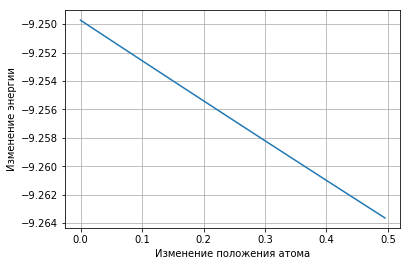

-9.26363823318


In [259]:
num = 280
coor = 2
h = 0.005
M = 100
mmm = []
ccc = []

print(
    E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, 
      num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)
)

# print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm))
for k in range(0, M):
    atoms[nm][coor] = atoms[nm][coor] + h
    EE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, 
           num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True) 
    # E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm)
    mmm.append(EE)
    ccc.append(k*h)  

import matplotlib.pyplot as plt
plt.plot(ccc, mmm)
plt.ylabel(r"Изменение энергии")
plt.xlabel(r"Изменение положения атома")
plt.grid(True)
plt.show()
    
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True))

# print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh,nm))

In [14]:
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, 2))

6.90602313923


In [47]:
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, 140))
atoms[140][0] = atoms[140][0] + 0.5
print(E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, 140))

4438.13048459
4438.13048459


In [59]:
a = np.array([1, 2, 3])
b = np.array([3, 2, 1])
print(a*b)

[3 4 3]


In [74]:
c = 10*[1, 1, 1]
#c[2][3]=[4,5]

In [77]:
print(c[5][2])

TypeError: 'int' object is not subscriptable

In [101]:
def ff(f=True):
    if f:
        print("True")
    else:
        print("False")
      
        
ff(f=True)

True


In [97]:
c = [1, 2, 3]
[c1, c2, c3] = c

print(c2)

2


In [102]:
for k in range(-2, 2):
    print(k)

-2
-1
0
1


In [107]:
print(L)

5


In [238]:
time_start = millis()
# число атомов в изучаемом белке
l = len(atoms)
# размеры шагов по ортам в ангстремах
h = [0.02, 0.02, 0.02]
# сколько шагов делаем вдоль каждого орта с учетом знака
L = 5
S = 0
# размер окрестности атома, по которой честно суммируе
r = 10
atoms_old = atoms
record = [0, 0, 0]
num = 434  # pyrandom.randrange(0, l)
nghb_d = nghb_dihedrals(dihedrals, num)
nghb_a = nghb_angles(angles, num)
nghb_b = nghb_bonds(bonds, num)
nghb_nb = nghbnb(atoms, num, r)[0]
nghbc = nghbnb(atoms, num, r)[1]
[Cx, Cy, Cz] = coef_nb(atoms, num, nghbc)

DE_elst = E_elst(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num) - \
          E_elst_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_nb)

E_old = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, 
          num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)

E_record = E_old
for px in range(-L, L + 1):
    for py in range(-L, L + 1):
        for pz in range(-L, L + 1):
            atoms[num][1] = atoms_old[num][1] + px * h[0]
            atoms[num][2] = atoms_old[num][2] + py * h[1]
            atoms[num][3] = atoms_old[num][3] + pz * h[2]
            E_new = DE_elst + Cx * px * h[0] + Cy * py * h[1] + Cz * pz * h[2] + E(atoms, dihedrals, angles, bonds,
                                                                                   neighbours, two_bonds_neigh,
                                                                                   three_bonds_neigh, num, nghb_d,
                                                                                   nghb_a, nghb_b, nghb_nb, full=False)
            #  "-0.05" чтобы не учитвать погрешности в аппроксимации
            if E_new < E_record - 0.05:  
                record = [px, py, pz]
                E_record = E_new
atoms = atoms_old
atoms[num][1] = atoms_old[num][1] + record[0] * h[0]
atoms[num][2] = atoms_old[num][2] + record[1] * h[1]
atoms[num][3] = atoms_old[num][3] + record[2] * h[2]

time_now = millis()
tm = (time_now - time_start) / 60000

ETRUE = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_d, nghb_a, nghb_b,
          nghb_nb, full=True)
DE = ETRUE - E_old

print("Энергия {}; Время (мин) {}".format(DE, tm))
k = 0
prp_atm(atoms, k)
os.system('./to-pdb atoms_out' + str(k) + '.csv output' + str(k) + '.pdb')

Энергия -169.7640675101076; Время (мин) 0.04665


0

In [229]:
print(nghb_d)
print(nghb_a)
print(nghb_b)
print(nghb_nb)
# print(nghbc)
print([Cx, Cy, Cz])

[998, 999, 1000, 1076, 1077, 1078, 1086, 1087, 1088, 1274, 1275, 1276, 1297, 1298, 1299, 1329, 1330, 1331, 1347, 1348, 1349]
[692, 738, 739, 746, 747, 757, 876, 877, 878, 896, 916, 931]
[420, 421, 422, 497]
[98, 112, 114, 125, 132, 162, 163, 167, 168, 172, 174, 176, 177, 188, 194, 198, 202, 203, 204, 206, 207, 208, 209, 210, 211, 215, 217, 218, 223, 225, 226, 230, 233, 236, 239, 243, 255, 257, 258, 259, 261, 263, 267, 268, 270, 271, 272, 273, 276, 278, 280, 282, 283, 286, 288, 291, 294, 295, 298, 300, 301, 303, 304, 305, 309, 310, 311, 312, 313, 317, 319, 320, 321, 324, 325, 327, 328, 331, 332, 333, 339, 340, 341, 343, 344, 346, 348, 349, 351, 354, 355, 360, 362, 365, 368, 371, 373, 376, 379, 382, 384, 386, 387, 391, 392, 393, 396, 399, 400, 402, 404, 405, 406, 407, 408, 410, 412, 415, 416, 422, 424, 425, 426, 428, 431, 432, 434, 436, 437, 438, 439, 441, 444, 449, 453, 454, 471, 472, 474, 475, 478, 482, 487, 490, 492, 496, 498, 503, 504, 509, 511, 512, 513, 514, 515, 516, 517, 520, 521

In [164]:
def dgdfg(nghbc):
    E = np.array([0, 0, 0])
    for j in nghbc:
        r = np.array([1, 1, 1])
        E[0] = E[0] + r[0]
        E[1] = E[1] + r[1]
        E[2] = E[2] + r[2]
    return E


nghbc = [1, 2, 3, 4, 76]
print(dgdfg(nghbc))


[5 5 5]


In [212]:
E = np.array([0.0, 0.0, 0.0])
print(E[0])

i = 5
j = 8
r = np.array(atoms[j][1:4]) - np.array(atoms[i][1:4])
ccc = atoms[i][6] * atoms[j][6] * (atoms[j][1] - atoms[i][1]) / pow(np.linalg.norm(r), 3)
print(ccc)

E[0] = E[0] + ccc 
print(E[0])
print(E[0] * 1389.38757)
print(ccc * 1389.38757)

0.0
1.63332281568e-05
1.63332281568e-05
0.022693184179
0.022693184179


In [175]:
print(
    (E[0] + atoms[i][6] * atoms[j][6] * (atoms[j][1] - atoms[i][1]) / pow(np.linalg.norm(r), 3)) 
    * 
    1389.38757
)

0.022693184179


In [210]:
y = np.array([0.0, 0.0, 0.0])
y[1] = y[1] + ccc
print(y)


[  0.00000000e+00   1.63332282e-05   0.00000000e+00]


In [239]:
num = 434
Delta = E_vdw(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num) - \
        E_vdw_m(atoms, neighbours, two_bonds_neigh, three_bonds_neigh, num, nghb_nb)

#print(nghb_nb)
print (Delta)

-0.0945943788217


In [249]:
aa = DE_elst + \
     Cx*px*h[0] + Cy*py*h[1] + Cz*pz*h[2] + \
     E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, 
       three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=False)

In [250]:
bb = E(atoms, dihedrals, angles, bonds, neighbours, two_bonds_neigh, 
       three_bonds_neigh, num, nghb_d, nghb_a, nghb_b, nghb_nb, full=True)

In [254]:
bb - aa

1.0280167218129463

In [252]:
DE_elst

3.2317934304534361